# Initial Setup
Import libraries and read in data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in initial data
df = pd.read_excel("Data/fact_table.xlsx")
df.head(2)

,Date,Platform,Platform ID,Product,Product ID,Revenue,Units,Price per Thousand Units,Device,Environment,Format
0,2019-09-01,Amazon,2A96TF7T,Social,Y2,107,NaN,NaN,Mobile,NaN,Video
1,2019-09-01,Amazon,2A96TF7T,Social,Y2,352,NaN,NaN,Mobile,NaN,Display


In [3]:
df.dtypes

Date                        datetime64[ns]
Platform                            object
Platform ID                         object
Product                             object
Product ID                          object
Revenue                              int64
Units                              float64
Price per Thousand Units           float64
Device                              object
Environment                         object
Format                              object
dtype: object

In [4]:
df.describe()

,Revenue,Units,Price per Thousand Units
count,1266.000000,3.140000e+02,255.000000
mean,12708.590047,2.118776e+08,0.142353
std,29881.008787,4.985606e+08,0.073108
min,101.000000,5.200000e+05,0.050000
25%,373.250000,3.142500e+06,0.050000
50%,1671.500000,2.948250e+07,0.200000
75%,11378.500000,9.933292e+07,0.200000
max,393078.000000,2.964600e+09,0.200000


In [5]:
# I prefer to flatten the columns as opposed to the multi-index, so have this function I may use after pivoting data
def flatten_cols(df):
    df.columns = [
        '_'.join(tuple(map(str, t))).strip() 
        for t in df.columns.values
        ]
    return df

# Revenue Trends
In the provided dataset, there are several sheets representing data from different companies.
Please provide visualizations showing revenue trends across the full set of clients, products,
devices, and formats over time.

__Rolling 24 Month Dataframe__
Create a rolling 24 month dataframe which is going to be used for both the customer and product analysis sections

In [6]:
# get 24 month period for analysis
start_date = date(2017, 9, 1).strftime("%Y-%m-%d")
last_24mos = df.loc[df['Date'] > start_date]
last_24mos['Date'].describe()

count                    1018
unique                     24
top       2018-10-01 00:00:00
freq                       49
first     2017-10-01 00:00:00
last      2019-09-01 00:00:00
Name: Date, dtype: object

In [7]:
# function which adds a YOY period for a rolling 24 months 
def add_yoy_period(df, period_id):
    """
    Dataframe specific function which is used to create a new column "yoy_period" that has last year and current year periods 
    distinctly identified. Must have 24 total periods (months).

    Parameters:
        df: the dataframe being used to derive yoy period from.
        col_name: the column you are using to derive the YOY periods (likely month, period, etc.)
  
    """
    # get the year over year periods
    periods = df[period_id].unique()
    periods_df = pd.DataFrame({period_id : periods}).sort_values(period_id, ascending=True)

    # get first 12 periods
    ly_period_df = periods_df.iloc[0:12, :]
    ly_period_df["yoy_period"] = "last year"

    # get last 12 periods
    cy_period_df = periods_df.iloc[12:, :]
    cy_period_df["yoy_period"] = "current year"

    periods_df = pd.concat([ly_period_df, cy_period_df])

    # merge with the existing dataframe
    df = df.merge(periods_df, on=period_id)

    return df

In [8]:
# add in a YOY period column
last_24mos_df = add_yoy_period(last_24mos, 'Date')

print("""Note: warning shouldn't be a problem, it is from the temporary table in the function that's merged with the 
passed in dataframe and then discarded""")

last_24mos_df.head(2)

Note: warning shouldn't be a problem, it is from the temporary table in the function that's merged with the 
passed in dataframe and then discarded


C:\Users\adamj\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\adamj\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Platform,Platform ID,Product,Product ID,Revenue,Units,Price per Thousand Units,Device,Environment,Format,yoy_period
0,2019-09-01,Amazon,2A96TF7T,Social,Y2,107,NaN,NaN,Mobile,NaN,Video,current year
1,2019-09-01,Amazon,2A96TF7T,Social,Y2,352,NaN,NaN,Mobile,NaN,Display,current year


## Overall Revenue Analysis

In [9]:
# create dataframe with rolling qtr revenue
qtr_df = df.pivot_table(index='Date', aggfunc={'Revenue': 'sum'}).fillna(0)
qtr_df['trailing_qtr_rev'] = qtr_df.rolling(3).sum().fillna(0)
qtr_df['yoy_qtr_rev_change'] = qtr_df['trailing_qtr_rev'] - qtr_df['trailing_qtr_rev'].shift(12)
qtr_df['yoy_qtr_rev_change_perc'] = (qtr_df['trailing_qtr_rev'] / qtr_df['trailing_qtr_rev'].shift(12) - 1) * 100

print("NaN are expected as there wouldn't be same periods the year prior for the earliest months in the dataset")
qtr_df.head()

NaN are expected as there wouldn't be same periods the year prior for the earliest months in the dataset


,Revenue,trailing_qtr_rev,yoy_qtr_rev_change,yoy_qtr_rev_change_perc
Date,,,,
2017-01-01,188665,0.0,NaN,NaN
2017-02-01,230227,0.0,NaN,NaN
2017-03-01,304013,722905.0,NaN,NaN
2017-04-01,195051,729291.0,NaN,NaN
2017-05-01,243337,742401.0,NaN,NaN


In [10]:
# limit to periods that have YOY comps
trim_qtr_df = qtr_df[14:].reset_index()

# add a year and month only label (drop day)
trim_qtr_df['year_month_label'] = trim_qtr_df['Date'].dt.to_period('m')

# create csv
# trim_qtr_df.to_csv("data_exports/overall_qtr_sales.csv", index=False)

trim_qtr_df.head()

,Date,Revenue,trailing_qtr_rev,yoy_qtr_rev_change,yoy_qtr_rev_change_perc,year_month_label
0,2018-03-01,551398,1525107.0,802202.0,110.969214,2018-03
1,2018-04-01,503398,1582148.0,852857.0,116.943305,2018-04
2,2018-05-01,433739,1488535.0,746134.0,100.502828,2018-05
3,2018-06-01,513957,1451094.0,676750.0,87.396558,2018-06
4,2018-07-01,656696,1604392.0,809042.0,101.721506,2018-07


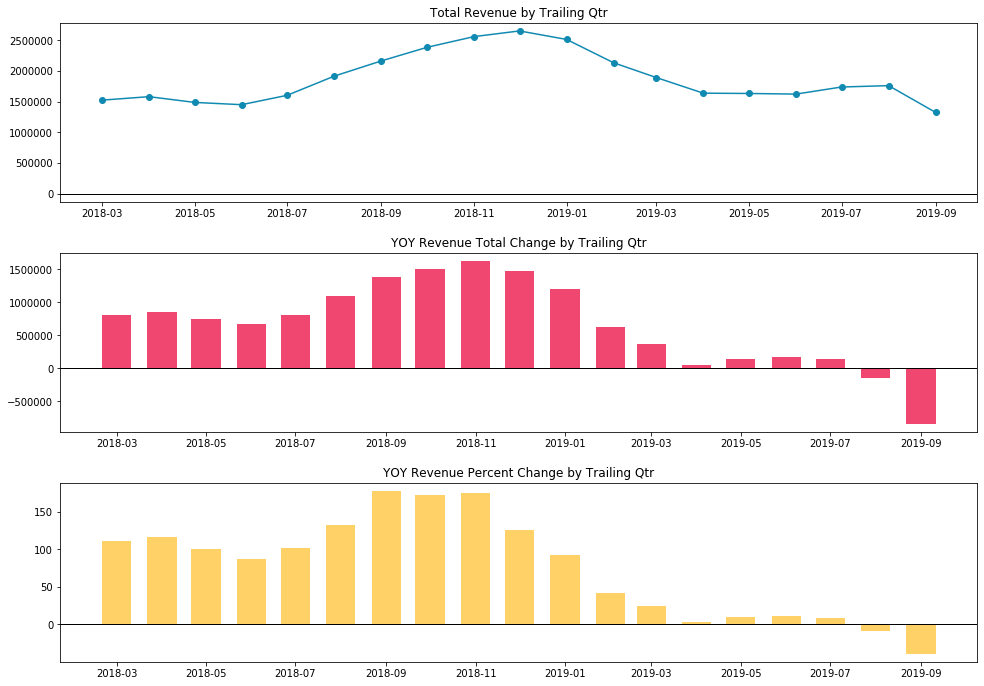

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
colors = ["#118AB2", "#EF476F", "#FFD166", "#06D6A0", "#EE754D", "#002E99"]

# plot rolling quarters
fig, axs = plt.subplots(3)
fig.set_size_inches(14, 10)
fig.tight_layout(pad=3)

axs[0].plot(trim_qtr_df['Date'], trim_qtr_df['trailing_qtr_rev'], color=colors[0], marker="o")
axs[0].set_title("Total Revenue by Trailing Qtr")

axs[1].bar(trim_qtr_df['Date'], trim_qtr_df['yoy_qtr_rev_change'], color=colors[1], width=20)
axs[1].set_title("YOY Revenue Total Change by Trailing Qtr")

axs[2].bar(trim_qtr_df['Date'], trim_qtr_df['yoy_qtr_rev_change_perc'], color=colors[2], width=20)
axs[2].set_title("YOY Revenue Percent Change by Trailing Qtr")


# add horizontal line at 0 for all axes
for x in range(len(axs)):
    axs[x].axhline(y=0, color='black', linewidth=1)

plt.show()

Findings
- Growth was at nearly 100% YOY by trailing quarter up until 2019 where it starts to go to 10-20%.
- There is a sharp decline in revenue in September 2019, hopefully due to a partial month of data.

## Platform Analysis
Will use the most recent rolling 24 months to hightlight current status and YOY change for platforms. Show the following platform views:
 - Total revenue
 - YOY revenue change
 - Number of products
 - YOY change in number of products

### Year Over Year

In [12]:
# get year over year customer revenue
cust_rev_pivot_df = last_24mos_df.pivot_table(index='Platform', columns='yoy_period', aggfunc={'Revenue': 'sum'}).fillna(0)
cust_rev_df = flatten_cols(cust_rev_pivot_df)
cust_rev_df['yoy_revenue_chg'] = (cust_rev_df['Revenue_current year'] / cust_rev_df['Revenue_last year'] - 1) * 100
cust_rev_df = cust_rev_df.reset_index()
cust_rev_df.head(2)

,Platform,Revenue_current year,Revenue_last year,yoy_revenue_chg
0,Amazon,174765.0,388213.0,-54.982188
1,Apple,896148.0,649654.0,37.942351


In [13]:
# get year over year product count
cust_prod_pivot_df = last_24mos_df.pivot_table(index='Platform', columns='yoy_period', values='Product',
                                              aggfunc=pd.Series.nunique).fillna(0)

# columns editing
cust_prod_df = cust_prod_pivot_df.rename(columns={'current year': 'products_current year',
                                                'last year': 'products_last year'})
cust_prod_df.columns.name = None

# add yoy change
cust_prod_df['yoy_products_chg'] = (cust_prod_df['products_current year'] / cust_prod_df['products_last year'] - 1) * 100

cust_prod_df = cust_prod_df.reset_index()
cust_prod_df.head(2)

,Platform,products_current year,products_last year,yoy_products_chg
0,Amazon,3.0,4.0,-25.0
1,Apple,1.0,1.0,0.0


In [14]:
# merge the revenue and product count dataframes
cust_df = pd.merge(cust_rev_df, cust_prod_df)
cust_df

,Platform,Revenue_current year,Revenue_last year,yoy_revenue_chg,products_current year,products_last year,yoy_products_chg
0,Amazon,174765.0,388213.0,-54.982188,3.0,4.0,-25.000000
1,Apple,896148.0,649654.0,37.942351,1.0,1.0,0.000000
2,Ganges,249213.0,574901.0,-56.651145,3.0,3.0,0.000000
3,Grape,0.0,718932.0,-100.000000,0.0,1.0,-100.000000
4,Kiwi,504376.0,339019.0,48.775142,4.0,3.0,33.333333
5,Mississippi,450680.0,414979.0,8.603086,3.0,4.0,-25.000000
6,Nile,970588.0,598652.0,62.128916,1.0,1.0,0.000000
7,Orange,581300.0,460682.0,26.182486,4.0,4.0,0.000000
8,Pear,2398582.0,609001.0,293.855183,1.0,1.0,0.000000
9,Yangtze,1270916.0,1561540.0,-18.611371,1.0,1.0,0.000000


[Text(0, 0.5, 'YOY Revenue Change'), Text(0.5, 0, 'Revenue')]

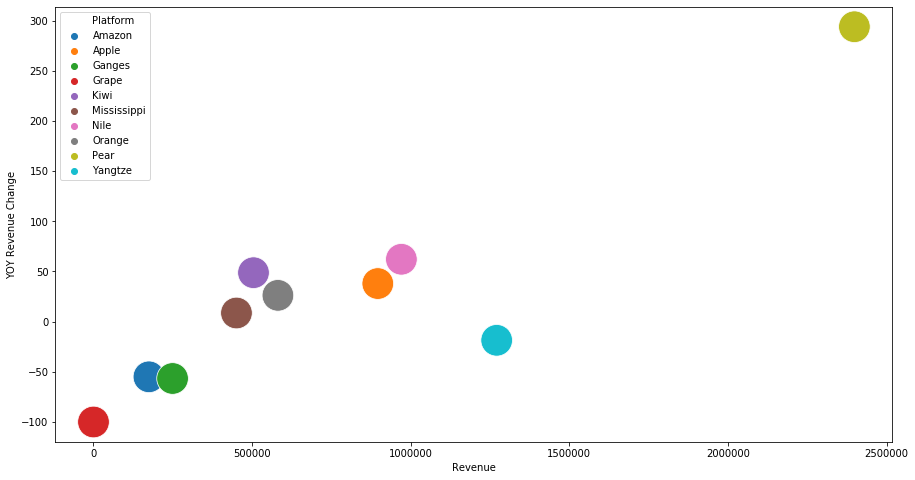

In [15]:
# scatterplot showing revenue for current year vs YOY revenue change
plt.figure(figsize=(15,8))
g = sns.scatterplot(x='Revenue_current year', y='yoy_revenue_chg', data=cust_df, hue='Platform', s=1000)
g.set(xlabel='Revenue', ylabel='YOY Revenue Change')

Findings:
- Pear has the had the highest revenue in the last 12 months, and the largest amount of growth.
- Grape has had $0 in revenue from Oct 2018 - Sept 2019 and has declined 100% as a dropped customer.

In [16]:
# unpivot for seaborn facet grid
melted_cust_df = pd.melt(cust_df, id_vars=['Platform'], value_vars=['Revenue_current year', 'Revenue_last year'])
melted_cust_df = melted_cust_df.sort_values('variable', ascending=False)
melted_cust_df = melted_cust_df.rename(columns={'variable':'period', 'value':'revenue'})
melted_cust_df['period'] = melted_cust_df['period'].str.replace('Revenue_','')
melted_cust_df.head(2)

,Platform,period,revenue
10,Amazon,last year,388213.0
11,Apple,last year,649654.0


C:\Users\adamj\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


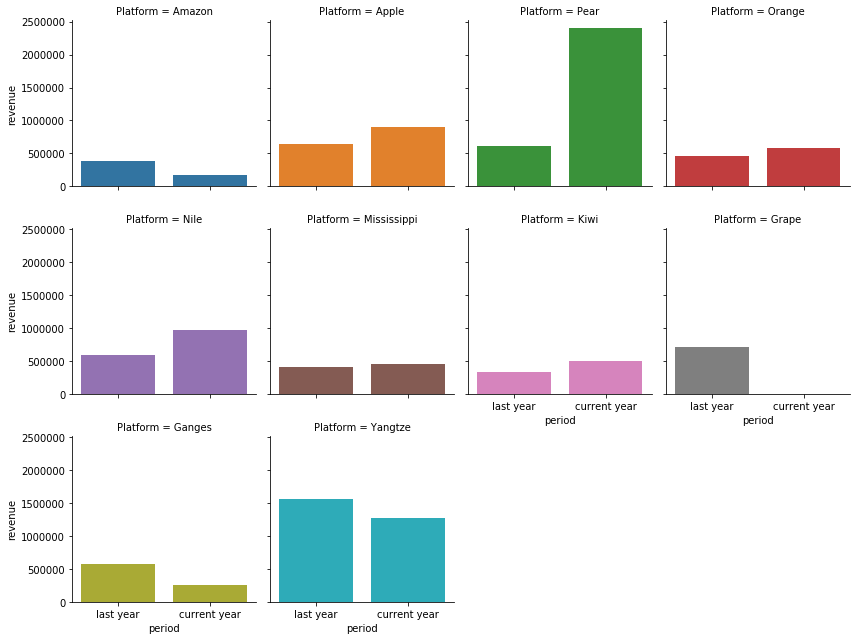

In [17]:
# YOY revenue bar plot by company
g = sns.FacetGrid(melted_cust_df, col='Platform', col_wrap=4, hue='Platform')
g = g.map(sns.barplot, 'period', 'revenue')

Findings:
- Yangtze may be a customer to watch.  While it is the 2nd largest company in revenue, it has had year over year decline.

### Platform Spend by Month

In [18]:
mon_rev_df = last_24mos_df.groupby(by=['Date', 'Platform']).agg({'Revenue': 'sum'}).reset_index()
mon_rev_df.head(2)

,Date,Platform,Revenue
0,2017-10-01,Amazon,36844
1,2017-10-01,Apple,13817


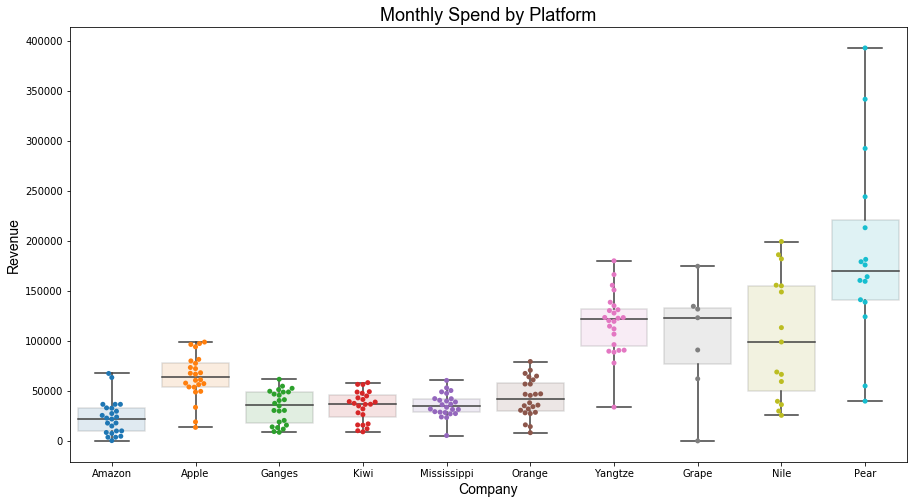

In [19]:
# Plot to show monthly revenue spend range and median amount by platform
plt.figure(figsize=(15,8))
ax = sns.swarmplot(x="Platform", y="Revenue", data=mon_rev_df, dodge=True)
ax = sns.boxplot(x="Platform", y="Revenue", data=mon_rev_df, whis=np.inf, boxprops=dict(alpha=.15))
ax.set_ylabel("Revenue", fontname="Arial", fontsize=14)
ax.set_xlabel("Company", fontname="Arial", fontsize=14)
ax.set_title("Monthly Spend by Platform", fontname='Arial', fontsize=18)
plt.show()

How to interpret:
- Each dot on the graph represents a companies spend for an individual month over the past 24 months.

Findings:
- Pear, Grape, and Yangtze all have wide ranges of revenue per month.

### Platform Highlights
Platform highlights and monthly analysis

In [20]:
def company_monthly_perf(df, platform):
    """
    Returns a companies monthly revenue by month.
        
    Parameters:
        df: the dataframe being used to derive monthly data from.
        company: the company you want monthly revenue for
    """
    
    # filter by the company and group revenue by month
    c_df = df.loc[(last_24mos_df['Platform'] == platform)]
    c_df = c_df.groupby(by=['Date']).agg({'Revenue': 'sum'}).reset_index()
    
    # get all months to merge with c_df (in case there are months with no revenue, this will show 0 for that month)
    m_df = df.groupby(by=df['Date']).agg({'Platform': 'count'}).reset_index().drop(columns=['Platform'])
    
    # merge the two dataframes, filling NaN months with 0 for revenue
    cm_df = pd.merge(c_df, m_df, how='outer').fillna(0)
    cm_df = cm_df.sort_values('Date', ascending=True)
    return cm_df

In [21]:
pear_mo_df = company_monthly_perf(last_24mos_df, 'Pear')
pear_mo_df.head(2)

,Date,Revenue
16,2017-10-01,0.0
17,2017-11-01,0.0


In [22]:
grape_mo_df = company_monthly_perf(last_24mos_df, 'Grape')
grape_mo_df.head(2)

,Date,Revenue
7,2017-10-01,0.0
0,2017-11-01,293.0


In [23]:
yangtze_mo_df = company_monthly_perf(last_24mos_df, 'Yangtze')
yangtze_mo_df.head(2)

,Date,Revenue
0,2017-10-01,122918
1,2017-11-01,130551


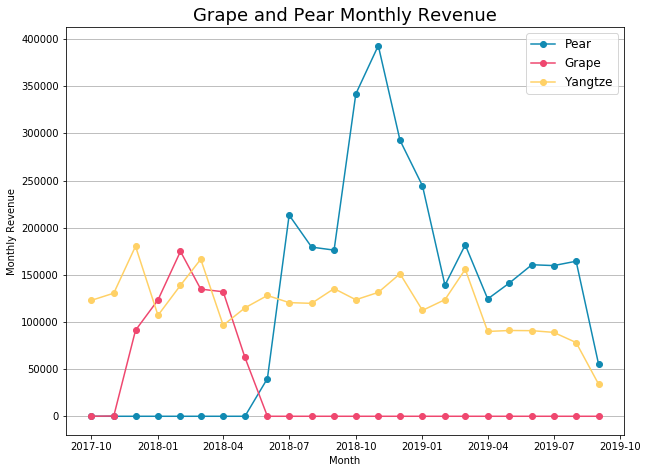

In [24]:
fig, axs = plt.subplots()
fig.set_size_inches(10, 7.5)
plt.plot(pear_mo_df['Date'], pear_mo_df['Revenue'], marker='o', c=colors[0])
plt.plot(grape_mo_df['Date'], grape_mo_df['Revenue'], marker='o', c=colors[1])
plt.plot(yangtze_mo_df['Date'], yangtze_mo_df['Revenue'], marker='o', c=colors[2])

plt.title("Grape and Pear Monthly Revenue", size=18)
plt.ylabel("Monthly Revenue")
plt.xlabel("Month")
plt.grid(axis='y')
plt.legend(['Pear', 'Grape', 'Yangtze'],loc="best", fontsize="large", fancybox=True)
plt.show()

Findings:
- Grape and Pear both contributed to the year over year decline in early 2019. 
- Grape discontinued purchases in June 2018. 
- Pear was lapping a year where it had higher monthly revenue.
- Yangtze has had a moderate month over month decline in revenue.

## Product Analysis
Will use the most recent rolling 24 months to hightlight current status and YOY change for products. Show the following product views:
 - Total revenue
 - YOY revenue change
 - Number of customer per product
 - YOY change in number of customers

In [25]:
# get year over year product revenue
prod_rev_pivot_df = last_24mos_df.pivot_table(index='Product', columns='yoy_period', aggfunc={'Revenue': 'sum'}).fillna(0)
prod_rev_df = flatten_cols(prod_rev_pivot_df)
prod_rev_df['yoy_revenue_chg'] = (prod_rev_df['Revenue_current year'] / prod_rev_df['Revenue_last year'] - 1) * 100
prod_rev_df = prod_rev_df.reset_index()

# drop experiment product type
prod_rev_df = prod_rev_df.replace([np.inf, -np.inf], np.nan).dropna()

prod_rev_df

,Product,Revenue_current year,Revenue_last year,yoy_revenue_chg
0,Core,6599420.0,5678794.0,16.211646
2,New Business,1158.0,16142.0,-92.826168
3,Social,745213.0,513425.0,45.145445
4,Video Platform,150554.0,107212.0,40.426445


In [26]:
# get year over year customer count
prod_cust_pivot_df = last_24mos_df.pivot_table(index='Product', columns='yoy_period', values='Platform',
                                              aggfunc=pd.Series.nunique).fillna(0)

# columns editing
prod_cust_df = prod_cust_pivot_df.rename(columns={'current year': 'customers_current year',
                                                'last year': 'customers_last year'})
cust_prod_df.columns.name = None

# add yoy change
prod_cust_df['yoy_customer_chg'] = (prod_cust_df['customers_current year'] / prod_cust_df['customers_last year'] - 1) * 100
prod_cust_df = prod_cust_df.reset_index()

# drop experiment product type
prod_cust_df = prod_cust_df.replace([np.inf, -np.inf], np.nan).dropna()

prod_cust_df

yoy_period,Product,customers_current year,customers_last year,yoy_customer_chg
0,Core,9.0,10.0,-10.000000
2,New Business,1.0,3.0,-66.666667
3,Social,5.0,5.0,0.000000
4,Video Platform,5.0,5.0,0.000000


In [27]:
# merge the revenue and customer count dataframes
prod_df = pd.merge(prod_rev_df, prod_cust_df)
prod_df

,Product,Revenue_current year,Revenue_last year,yoy_revenue_chg,customers_current year,customers_last year,yoy_customer_chg
0,Core,6599420.0,5678794.0,16.211646,9.0,10.0,-10.000000
1,New Business,1158.0,16142.0,-92.826168,1.0,3.0,-66.666667
2,Social,745213.0,513425.0,45.145445,5.0,5.0,0.000000
3,Video Platform,150554.0,107212.0,40.426445,5.0,5.0,0.000000


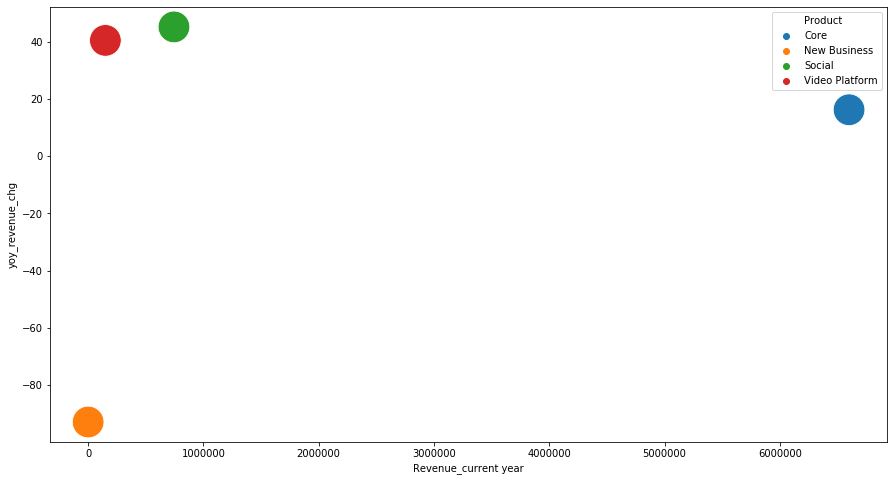

In [28]:
# basic plot showing revenue for current year vs YOY revenue change
plt.figure(figsize=(15,8))
g = sns.scatterplot(x='Revenue_current year', y='yoy_revenue_chg', data=prod_df, hue='Product', s=1000)

Finding:
- While smaller in revenue compared to core, social and video platform both have significant growth up 45% and 40% respectively.

In [29]:
# unpivot for seaborn facet grid
melted_prod_df = pd.melt(prod_df, id_vars=['Product'], value_vars=['Revenue_current year', 'Revenue_last year'])
melted_prod_df = melted_prod_df.sort_values('variable', ascending=False)
melted_prod_df = melted_prod_df.rename(columns={'variable':'period', 'value':'revenue'})
melted_prod_df['period'] = melted_prod_df['period'].str.replace('Revenue_','')
melted_prod_df.head(2)

,Product,period,revenue
4,Core,last year,5678794.0
5,New Business,last year,16142.0


C:\Users\adamj\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


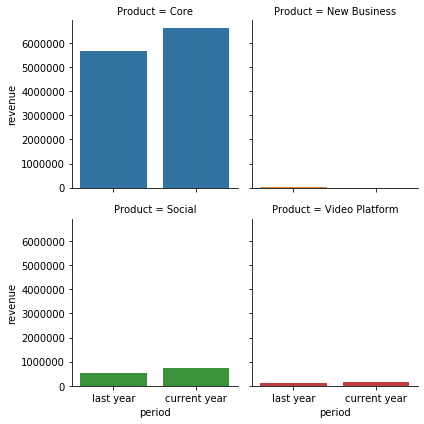

In [30]:
# YOY revenue bar plot by company
g = sns.FacetGrid(melted_prod_df, col='Product', col_wrap=2, hue='Product')
g = g.map(sns.barplot, 'period', 'revenue')

Finding:
- While video and social are growing higher from a percentage standpoint, core still represents the most growth from a revenue standpoint.

## Format Analysis
Focus on video

In [31]:
# create revenue by format df for last 2 years
vf_df = last_24mos_df.groupby(by=['Date', 'Format']).agg({'Revenue': 'sum'}).unstack('Format')
vf_df = flatten_cols(vf_df)
vf_df['total_revenue'] = vf_df['Revenue_Display'] + vf_df['Revenue_Video']
vf_df.head(2)

,Revenue_Display,Revenue_Video,total_revenue
Date,,,
2017-10-01,289580,23662,313242
2017-11-01,309087,21141,330228


In [32]:
# convert to percentages
vf_perc_df = vf_df.div(vf_df['total_revenue'], axis=0) * 100 
vf_perc_df = vf_perc_df.reset_index()
vf_perc_df.head(2)

,Date,Revenue_Display,Revenue_Video,total_revenue
0,2017-10-01,92.446096,7.553904,100.0
1,2017-11-01,93.598060,6.401940,100.0


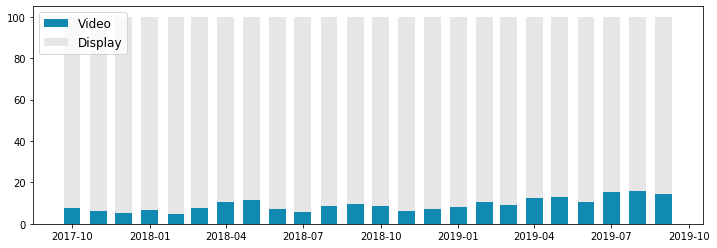

In [33]:
# plot the percent of revenue from video by month
plt.figure(figsize=(12,4))
ax1 = plt.bar(vf_perc_df['Date'], vf_perc_df['Revenue_Video'], width=20, color=colors[0])
ax2 = plt.bar(vf_perc_df['Date'], vf_perc_df['Revenue_Display'], width=20, bottom=vf_perc_df['Revenue_Video'], color='#e6e6e6')
plt.legend(['Video', 'Display'],loc='upper left', fontsize=12, fancybox=True)
plt.show()

Finding:
- Share of revenue by video format has been higher in the most recent quarter.

## Device Analysis

In [34]:
# create revenue by format df for last 2 years
dev_df = last_24mos_df.groupby(by=['Date', 'Device']).agg({'Revenue': 'sum'}).unstack('Device')
dev_df = flatten_cols(dev_df)
dev_df['total_revenue'] = dev_df['Revenue_Desktop'] + dev_df['Revenue_Mobile']
dev_df.head(2)

,Revenue_Desktop,Revenue_Mobile,total_revenue
Date,,,
2017-10-01,160938,152304,313242
2017-11-01,178832,151396,330228


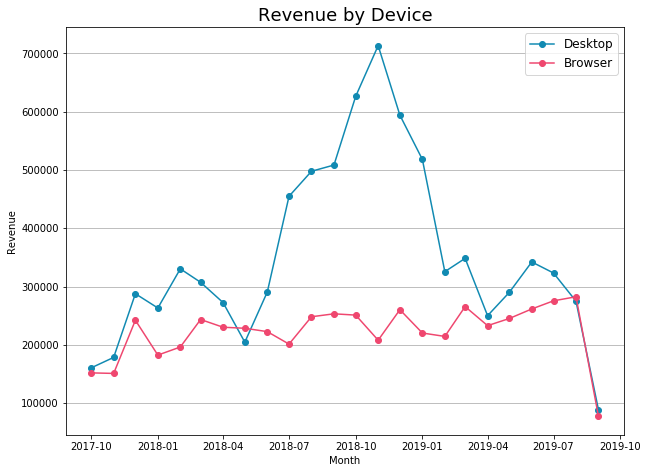

In [35]:
fig, axs = plt.subplots()
fig.set_size_inches(10, 7.5)
plt.plot(dev_df.index, dev_df['Revenue_Desktop'], marker='o', c=colors[0])
plt.plot(dev_df.index, dev_df['Revenue_Mobile'], marker='o', c=colors[1])

plt.title("Revenue by Device", size=18)
plt.ylabel("Revenue")
plt.xlabel("Month")
plt.grid(axis='y')
plt.legend(['Desktop', 'Browser'],loc="best", fontsize="large", fancybox=True)
plt.show()

Finding:
- The spike in revenue in late 2018 was driven by desktop devices

# About Me
Thank you for taking the time to review my notebook! To learn more about me please visit my professional website at:

https://admiral810.github.io/ 

<img src="images/me.png">